# Gene selection and screening for genes for MF9 subpool: mf4plus

by Pu Zheng

2024.10.1


> Dian's slide tag data:
>>/lab/solexa_weissman/puzheng/Sequencing_data/DianYangLab/adata_merged.scanvi_slidetags.all.assigned.raw.h5ad
>>/lab/solexa_weissman/puzheng/Sequencing_data/DianYangLab/adata_merged.scanvi_slidetags.immune.assigned_v2.h5ad
>>
> Katie's 10x data:
>> 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import scanpy as sc
sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=180, dpi_save=300, 
                              frameon=False, figsize=(4, 4), 
                              fontsize=8, facecolor='white')

In [2]:
library_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes'
print(f"- FISH probe libraries stored in folder: {library_master_folder}")

# Define the output files
library_folder = os.path.join(library_master_folder, '4T1_MERFISH', 'MF9_4T1Lung_mf4plus')
print(f"- library will be saved in: {library_folder}")
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
    print(f"-- create library_folder: {library_folder}")

- FISH probe libraries stored in folder: /lab/solexa_weissman/puzheng/MERFISH_Probes
- library will be saved in: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus


# Load and process sequencing data

In [3]:
# load slide-tag data
sequencing_data_filename = '/lab/solexa_weissman/puzheng/KP_mouse/SlideTag/adata_merged.scanvi_slidetags.all.assigned.raw.h5ad'
# load 
slide_adata = sc.read_h5ad(sequencing_data_filename)

In [4]:
slide_adata.obs.head()

,tumor,batch,cell_type,tech,_scvi_batch,_scvi_labels,celltype_scanvi,C_scANVI,scanvi_leiden,Predicted_CellTypesKNN,Predicted_CellTypesRF,Predicted_CellTypesSVM,Predicted_CellTypesAdaBoost,Predicted_CellTypes_Consensus_labels,Predicted_CellTypes_Consensus_freqs,scanvi_leiden2,CellType_Remapped,CellType_Remapped_Coarse
L1.AAACCCAAGCCTATCA,False,L1,Unknown,Slidetag,0,21,Unknown,Gastric-like,1,Endoderm-like,Gastric-like,Endoderm-like,Gastric-like,Gastric-like,0.6,7,Gastric-like,Gastric-like
L1.AAACCCAAGGCCGCTT,False,L1,Unknown,Slidetag,0,21,Unknown,Mesenchymal,4,Mesenchymal,Mesenchymal,Mesenchymal,Mesenchymal,Mesenchymal,1.0,4,Early EMT,EMT
L1.AAACCCAAGTATGAAC,False,L1,Unknown,Slidetag,0,21,Unknown,AT1-like,11,AT1-like,AT1-like,AT1-like,Gastric-like,AT1-like,0.8,2,Pre-EMT,Pre-EMT
L1.AAACCCAAGTGCTACT,True,L1,Unknown,Slidetag,0,21,Unknown,Endoderm-like,5,Endoderm-like,Endoderm-like,Endoderm-like,Endoderm-like,Endoderm-like,1.0,17,Endoderm-like,Endoderm-like
L1.AAACCCACACTACCGG,False,L1,Unknown,Slidetag,0,21,Unknown,AT2-like,0,Mesenchymal,AT2-like,AT2-like,Endoderm-like,AT2-like,0.6,0,AT2,Epithelial


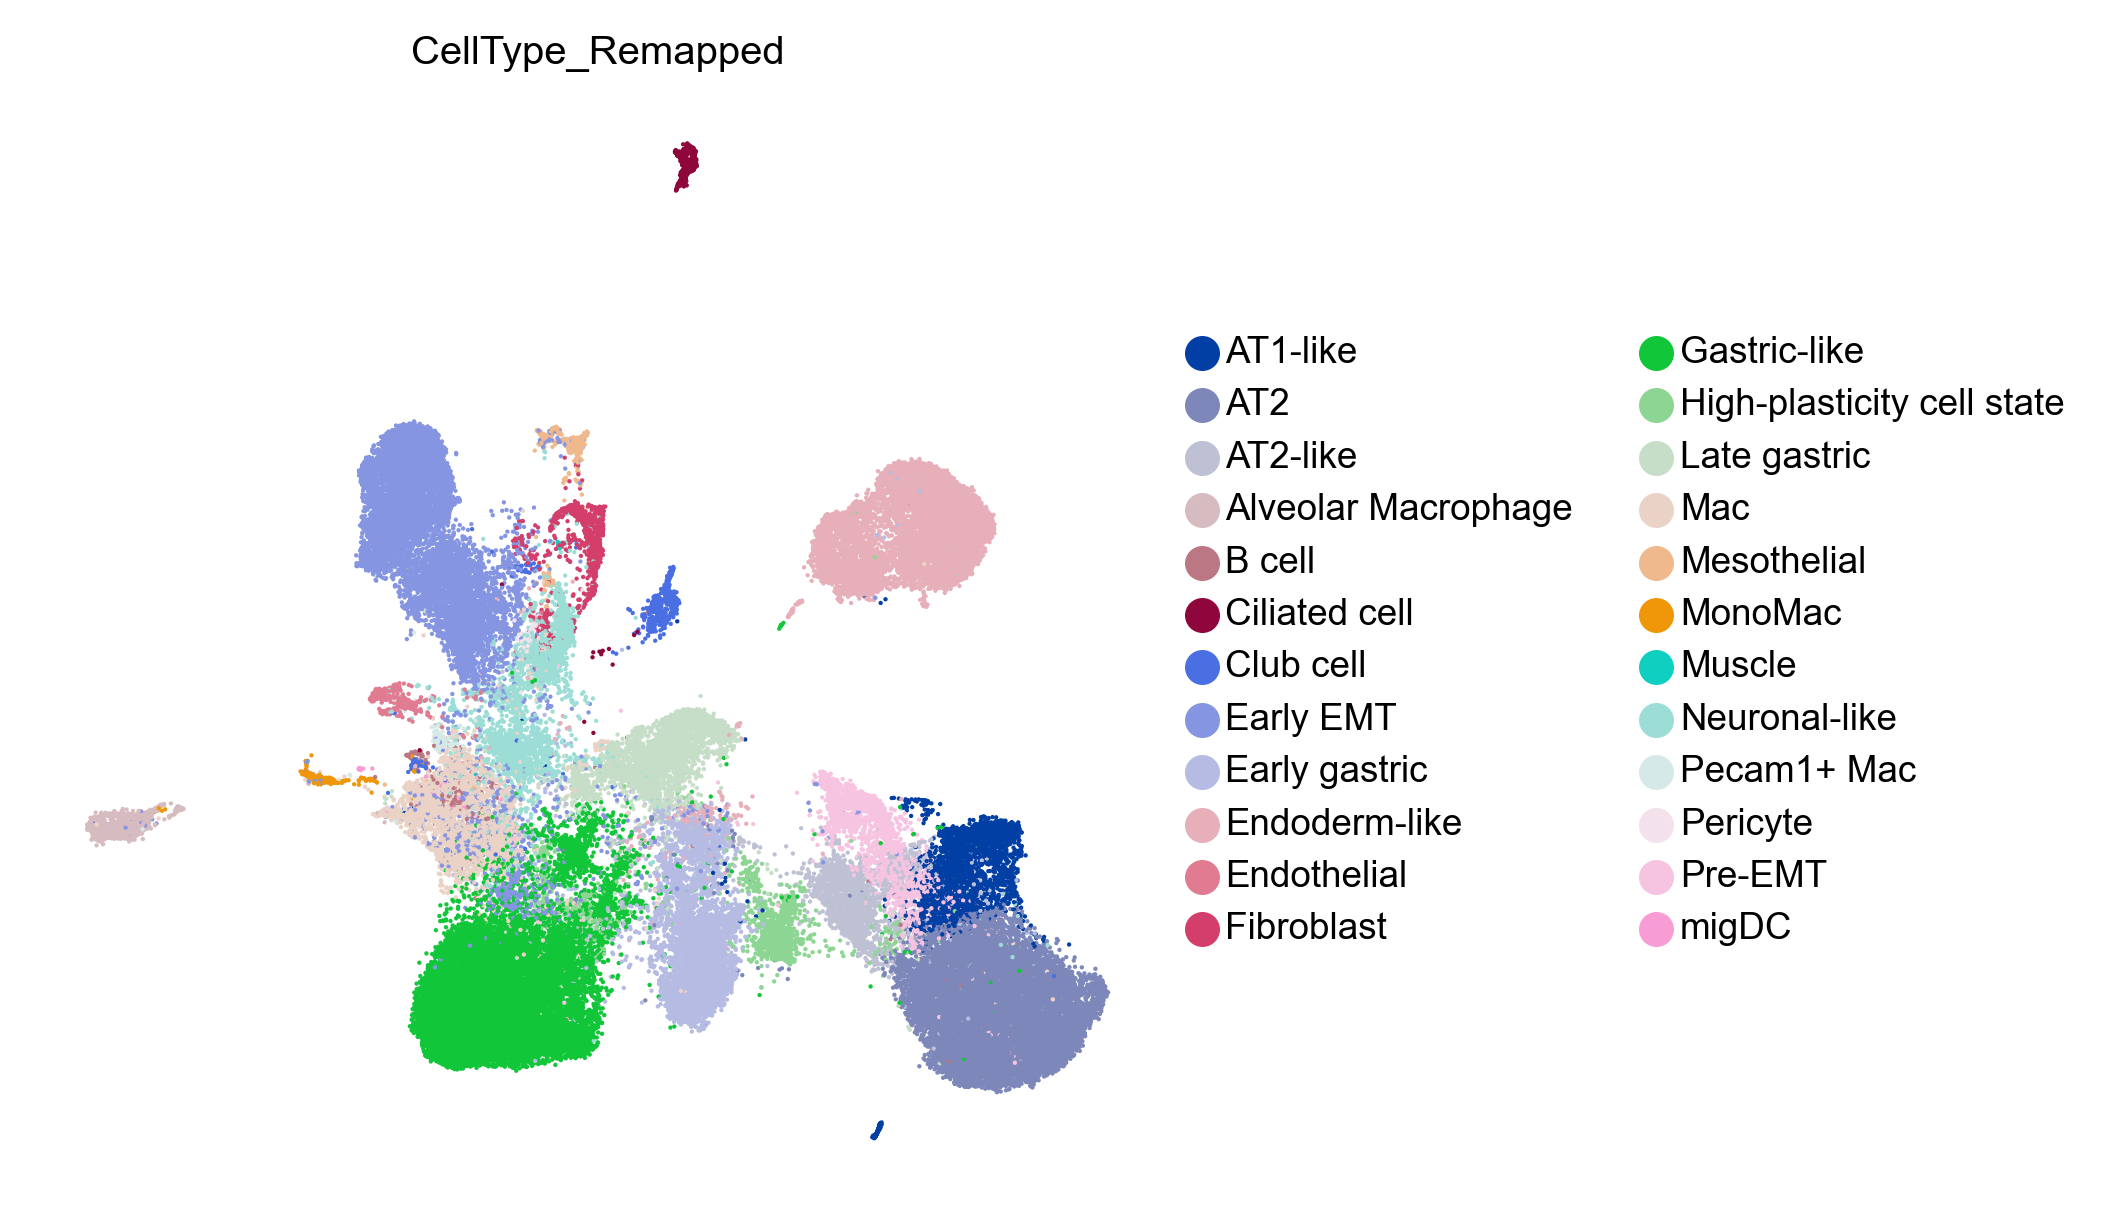

In [5]:
slide_umap = sc.pl.umap(slide_adata, color=['CellType_Remapped'], s=3)

In [6]:
# Load 4T1:
# load 
seq_4T1_adata = sc.read_h5ad(r'/lab/solexa_weissman/kyost/pe_lineage/230427_4T1_10X/F112_F122_filterCells_finalLabels.h5ad')
# update Level2_ident, its bugged in the h5ad file
label_filename = r'/lab/solexa_weissman/kyost/pe_lineage/230427_4T1_10X/F112_F122_filterCells_finalLabels_metadata.txt'
label_df = pd.read_table(label_filename)
# level 2
index_to_label = {_i:_r['Level2_ident'] for _i, _r in label_df.iterrows()}
seq_4T1_adata.obs['Level2_ident'] = [index_to_label[_i] for _i in seq_4T1_adata.obs.index]
# level 1
index_to_label = {_i:_r['Level1_ident'] for _i, _r in label_df.iterrows()}
seq_4T1_adata.obs['Level1_ident'] = [index_to_label[_i] for _i in seq_4T1_adata.obs.index]


In [7]:
seq_4T1_adata.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,RNA_snn_res.0.8,seurat_clusters,pANN,DF.classifications_1,DF.classifications_2,percent.mt,DF.classifications,SingleR_labels,RNA_snn_res.0.3,RNA_snn_res.0.2,RNA_snn_res.0.1,RNA_snn_res.0.15,RNA_snn_res.0.17,RNA_snn_res.0.18,RNA_snn_res.0.25,Level1_ident,Level2_ident
F112_F122_tumor_GEX_AAACCCAAGTTCGGTT-1,F112_F122_tumor_GEX,2488.0,1135,0,8,0.089231,Singlet,Singlet,0.401929,Singlet,Granulocytes,9,8,0,6,7,7,9,Neutrophil,Neutrophil_mN5_mN3
F112_F122_tumor_GEX_AAACCCAAGTTGGAAT-1,F112_F122_tumor_GEX,609.0,335,0,8,0.043846,Singlet,Singlet,1.313629,Singlet,Granulocytes,9,8,0,6,7,7,9,Neutrophil,Neutrophil_mN5_mN3
F112_F122_tumor_GEX_AAACCCAAGTTGGCTT-1,F112_F122_tumor_GEX,2180.0,907,0,8,0.060769,Singlet,Singlet,0.091743,Singlet,Granulocytes,9,8,0,6,7,7,9,Neutrophil,Neutrophil_mN5_mN3
F112_F122_tumor_GEX_AAACCCACAAGCGCTC-1,F112_F122_tumor_GEX,18379.0,2961,7,2,0.232308,Singlet,Singlet,0.821590,Singlet,Granulocytes,1,2,3,3,2,2,1,Neutrophil,Neutrophil_mN1_liver
F112_F122_tumor_GEX_AAACCCACAATCGCGC-1,F112_F122_tumor_GEX,2829.0,1083,0,8,0.044615,Singlet,Singlet,0.070696,Singlet,Granulocytes,9,8,0,6,7,7,9,Neutrophil,Neutrophil_mN5_mN3


In [8]:
# slide data calculate mean exp for each type
min_celltype_count = 100
slide_mean_exps = []
slide_types = []
for  _type, _count in slide_adata.obs['CellType_Remapped'].value_counts().items():
    if _count < min_celltype_count:
        continue
    type_mean = slide_adata[slide_adata.obs['CellType_Remapped']==_type].raw.X.mean(axis=0)
    #print(_type, type_mean)
    slide_mean_exps.append(type_mean)
    slide_types.append(_type)
slide_mean_exp_df = pd.DataFrame(np.concatenate(slide_mean_exps).T, columns=slide_types, index=slide_adata.raw.var_names)
slide_mean_fraction_df = slide_mean_exp_df.div(slide_mean_exp_df.sum(0), 1)

seq_4T1_mean_exps = []
seq_4T1_types = []
for  _type, _count in seq_4T1_adata.obs['Level2_ident'].value_counts().items():
    if _count < min_celltype_count:
        continue
    type_mean = seq_4T1_adata[seq_4T1_adata.obs['Level2_ident']==_type].raw.X.mean(axis=0)
    #print(_type, type_mean)
    seq_4T1_mean_exps.append(type_mean)
    seq_4T1_types.append(_type)
seq_mean_exp_df = pd.DataFrame(np.concatenate(seq_4T1_mean_exps).T, columns=seq_4T1_types, index=seq_4T1_adata.raw.var_names)
seq_mean_fraction_df = seq_mean_exp_df.div(seq_mean_exp_df.sum(0), 1)


# summarize:
mean_exp_df = pd.merge(slide_mean_exp_df, seq_mean_exp_df, 'inner', left_index=True, right_index=True, suffixes=('_slide', ''))
mean_fraction_df = pd.merge(slide_mean_fraction_df, seq_mean_fraction_df, 'inner', left_index=True, right_index=True, suffixes=('_slide', '')) 

In [9]:
mean_exp_df.head()

,Gastric-like,AT2,Early EMT,Endoderm-like,Early gastric,Late gastric,Mac,AT1-like,Neuronal-like,Pre-EMT,...,NK_cells,Tregs,4T1_Hmga2_high,Endothelial,Tcell_CD8_exhausted,cDC1,Fibroblast,Hepatocyte,pDC,4T1_Nestin_high
0610009B22Rik,0.015722,0.007808,0.025194,0.014377,0.013574,0.021884,0.012761,0.006327,0.015858,0.014297,...,0.032587,0.026385,0.689751,0.087087,0.034483,0.101695,0.389262,0.176056,0.095588,0.108333
0610009L18Rik,0.014219,0.010902,0.017618,0.014590,0.014288,0.016013,0.017377,0.008135,0.013724,0.013072,...,0.006110,0.018470,0.066482,0.006006,0.025078,0.027119,0.046980,0.000000,0.014706,0.008333
0610010F05Rik,0.144253,0.145856,0.239517,0.108200,0.136453,0.174540,0.208797,0.109069,0.204941,0.175654,...,0.138493,0.042216,0.792244,0.246246,0.078370,0.138983,0.530201,0.021127,0.066176,0.216667
0610010K14Rik,0.001315,0.001842,0.009161,0.001917,0.002143,0.004003,0.003530,0.001506,0.005185,0.003676,...,0.193483,0.139842,0.966759,0.189189,0.244514,0.247458,0.610738,0.119718,0.242647,0.741667
0610012D04Rik,0.010899,0.003757,0.003171,0.007987,0.009287,0.006672,0.012761,0.001506,0.007014,0.003268,...,0.008147,0.000000,0.000000,0.000000,0.000000,0.003390,0.006711,0.000000,0.000000,0.000000


In [10]:
mean_fraction_df.head()

,Gastric-like,AT2,Early EMT,Endoderm-like,Early gastric,Late gastric,Mac,AT1-like,Neuronal-like,Pre-EMT,...,NK_cells,Tregs,4T1_Hmga2_high,Endothelial,Tcell_CD8_exhausted,cDC1,Fibroblast,Hepatocyte,pDC,4T1_Nestin_high
0610009B22Rik,3.553712e-06,3.707232e-06,5.368929e-06,4.133769e-06,4.290234e-06,0.000006,2.696923e-06,3.177370e-06,0.000004,0.000005,...,0.000007,0.000005,0.000033,1.442607e-05,0.000006,1.191904e-05,1.762524e-05,0.000056,0.000017,1.079917e-05
0610009L18Rik,3.213915e-06,5.176135e-06,3.754496e-06,4.195010e-06,4.516035e-06,0.000004,3.672405e-06,4.085190e-06,0.000003,0.000004,...,0.000001,0.000004,0.000003,9.949011e-07,0.000004,3.178411e-06,2.127184e-06,0.000000,0.000003,8.307055e-07
0610010F05Rik,3.260637e-05,6.924829e-05,5.104237e-05,3.111044e-05,4.312814e-05,0.000046,4.412624e-05,5.477180e-05,0.000050,0.000060,...,0.000029,0.000009,0.000038,4.079095e-05,0.000013,1.628936e-05,2.400679e-05,0.000007,0.000012,2.159834e-05
0610010K14Rik,2.973225e-07,8.743471e-07,1.952338e-06,5.511692e-07,6.774053e-07,0.000001,7.459573e-07,7.565166e-07,0.000001,0.000001,...,0.000041,0.000029,0.000047,3.133939e-05,0.000040,2.900300e-05,2.765339e-05,0.000038,0.000043,7.393279e-05
0610012D04Rik,2.463529e-06,1.783668e-06,6.758093e-07,2.296538e-06,2.935423e-06,0.000002,2.696923e-06,7.565166e-07,0.000002,0.000001,...,0.000002,0.000000,0.000000,0.000000e+00,0.000000,3.973014e-07,3.038834e-07,0.000000,0.000000,0.000000e+00


# Filter selected genes

In [11]:
# manual list v1 from Katie:
#manual_list_filename = os.path.join(library_folder, '20241001-MF9_gene_selection.xlsx')
#manual_list_df = pd.read_excel(manual_list_filename, 'MF4_plus_v2', header=0)
#manual_genes = manual_list_df['Gene'].dropna().values
manual_genes = pd.read_csv(os.path.join(library_folder, 'mf4plus_base.csv'))['Gene'].values
print(len(manual_genes))

150


In [12]:
# Load manual_lung_genes:
lung_genes = pd.read_csv(os.path.join(library_folder, 'manual_lung_genes.csv'))['Gene'].values
print(len(lung_genes))

25


In [13]:
# assume manual genes are exactly what we need:
marker_genes = list(manual_genes) + [_g for _g in lung_genes if _g not in manual_genes]
print(len(marker_genes))

175


## Redo UMAP of selected genes

/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


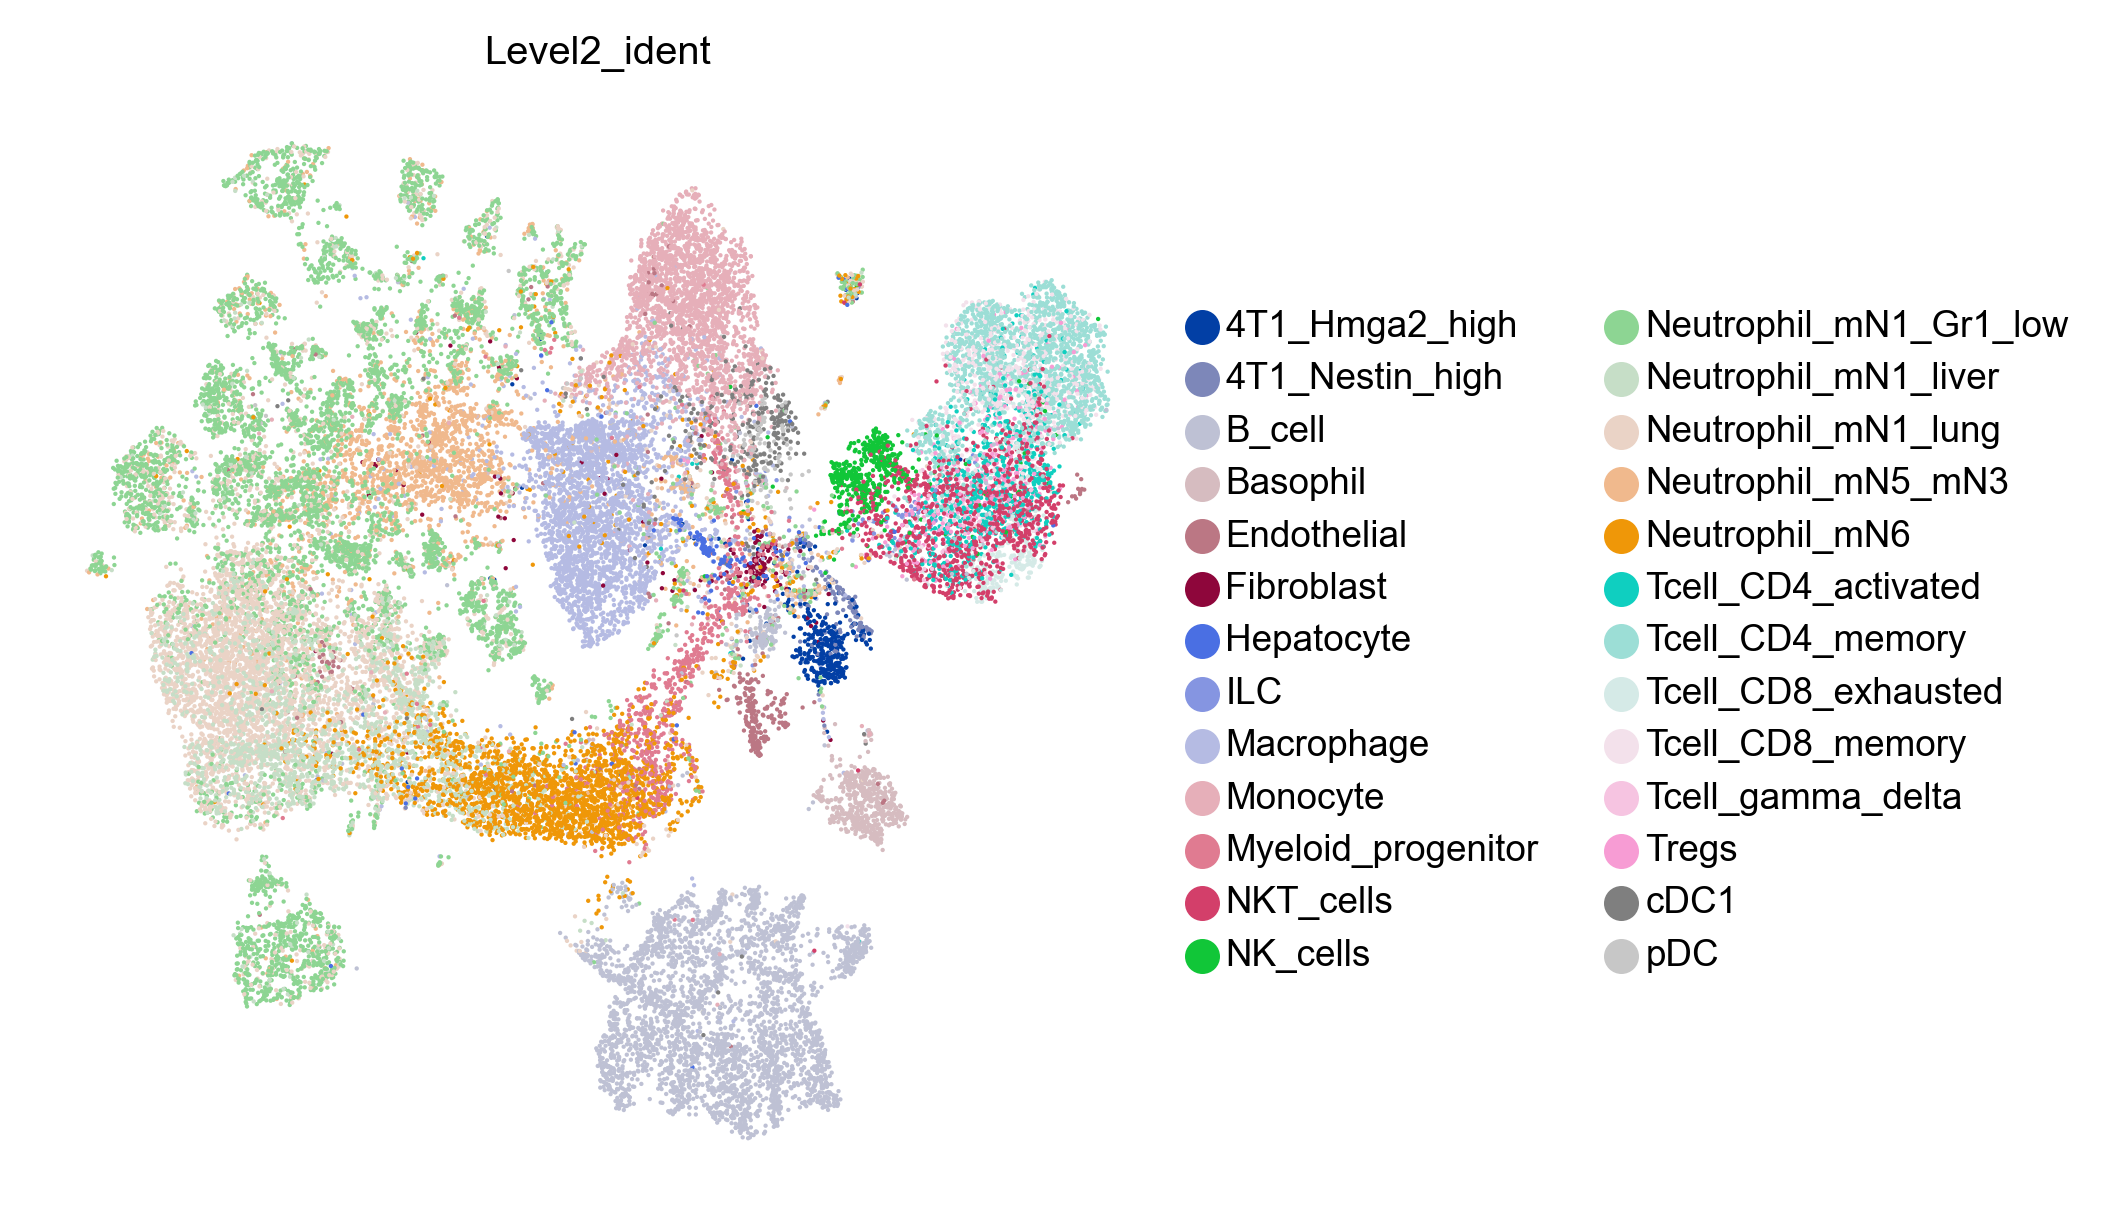

CPU times: user 1min 55s, sys: 10.3 s, total: 2min 5s
Wall time: 1min 4s


In [14]:
%%time
# Calculate the mean counts
filtered_adata = seq_4T1_adata.copy()
sc.pp.calculate_qc_metrics(filtered_adata, percent_top=None, log1p=False, inplace=True, use_raw=True)
# Validate that the selected genes recapitulate the cluster structures
adata_selected = filtered_adata[:, filtered_adata.var.index.isin(marker_genes)]
# Principal component analysis
sc.tl.pca(adata_selected, svd_solver='arpack')
# Computing the neighborhood graph
sc.pp.neighbors(adata_selected, n_neighbors=10, n_pcs=20)
# Embed with UMAP
sc.tl.umap(adata_selected)
# Plot the clusters
sc.pl.umap(adata_selected, color='Level2_ident', s=3)

/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:668: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


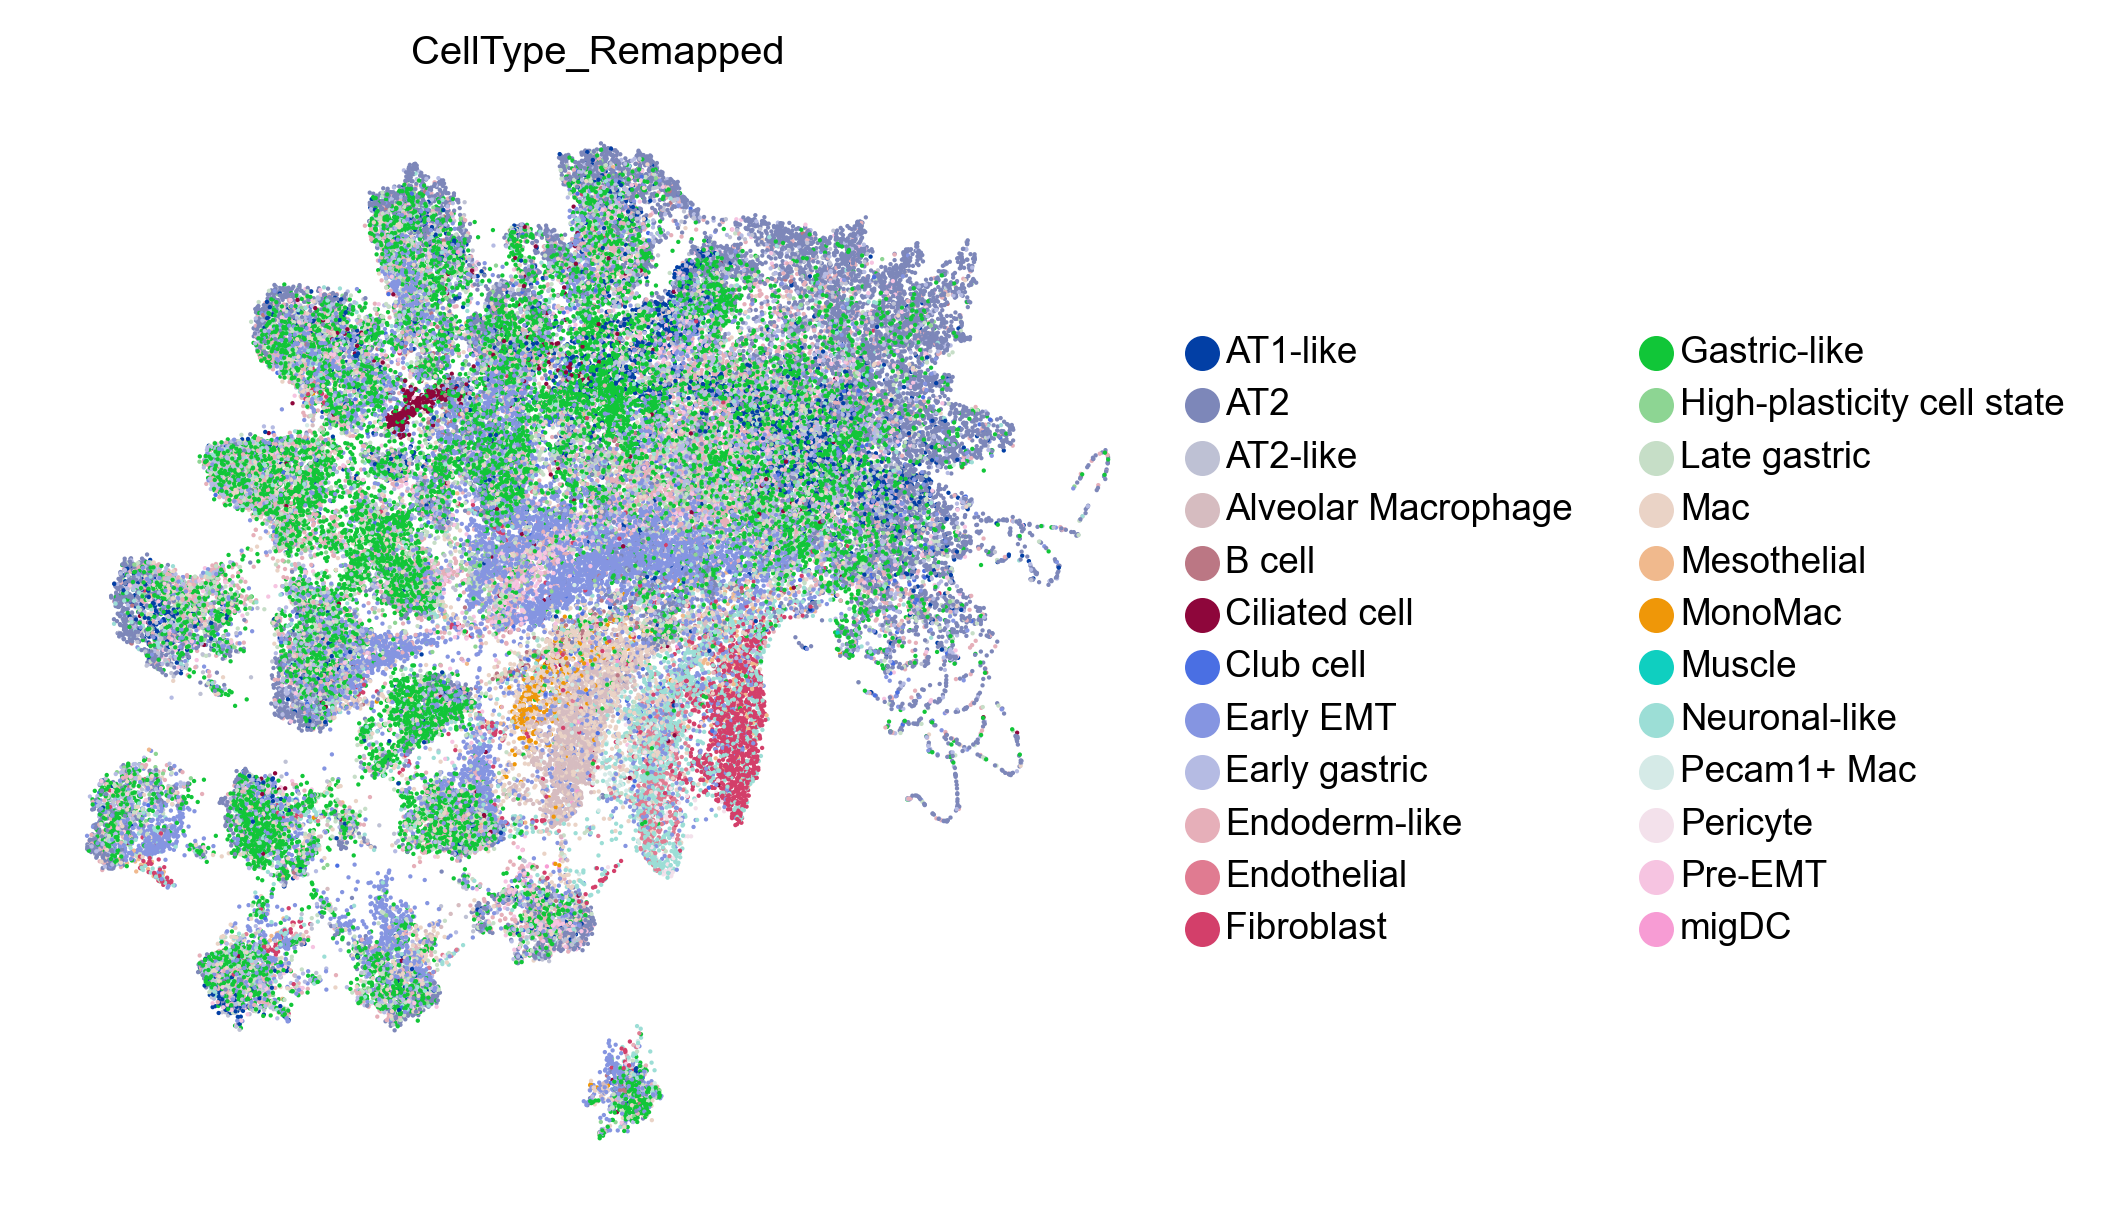

In [15]:
# Calculate the mean counts
filtered_slide_adata = slide_adata.copy()
sc.pp.calculate_qc_metrics(filtered_slide_adata, percent_top=None, log1p=False, inplace=True, use_raw=True)
# Validate that the selected genes recapitulate the cluster structures
slide_adata_selected = filtered_slide_adata[:, filtered_slide_adata.var.index.isin(marker_genes)]

# Regress out total counts
sc.pp.regress_out(slide_adata_selected, 'total_counts')
# Convert gene expressions to Z-scores
sc.pp.scale(slide_adata_selected, max_value=10)

# Principal component analysis
sc.tl.pca(slide_adata_selected, svd_solver='arpack')

# Computing the neighborhood graph
sc.pp.neighbors(slide_adata_selected, n_neighbors=10, n_pcs=30)
# Embed with UMAP
sc.tl.umap(slide_adata_selected)
# Plot the clusters
sc.pl.umap(slide_adata_selected, color='CellType_Remapped', s=3)

## Filter marker genes by expression

In [16]:
total_fraction_df = mean_fraction_df.loc[marker_genes]

In [17]:
# remove gene with very high umi
gene_to_remove = []
soft_celltype_th = 2
hard_xs, hard_ys = np.where(total_fraction_df > 0.01)
soft_xs, soft_ys = np.where(total_fraction_df > 0.005)

for _ix, _iy in zip(hard_xs, hard_ys):
    _gene = total_fraction_df.index[_ix]
    _type = total_fraction_df.columns[_iy]
    if _gene not in gene_to_remove:
        print(f"hard remove: {_gene}")
        gene_to_remove.append(_gene)
print(f"hard remove: {gene_to_remove}")
# soft
for _ix, _iy in zip(soft_xs, soft_ys):
    _gene = total_fraction_df.index[_ix]
    _type = total_fraction_df.columns[_iy]
    
    if _gene not in gene_to_remove and np.sum(soft_xs==_ix) >= soft_celltype_th:
        print(f"soft remove: {_gene}")
        gene_to_remove.append(_gene)
print(f"soft remove: {gene_to_remove}")

hard remove: []
soft remove: []


In [18]:
#kept_marker_genes = np.array([_g for _g in marker_genes if _g not in gene_to_remove])

# manually keep all genes:
kept_marker_genes = marker_genes

# Save

In [19]:
library_folder

'/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus'

In [20]:
target_gene_mean_exp_filename = os.path.join(library_folder, 'marker_gene_mean_exp.csv')
# save
print(f"saving mean_exp for target genes: {target_gene_mean_exp_filename}")
mean_exp_df.loc[kept_marker_genes].to_csv(target_gene_mean_exp_filename)
print(len(mean_exp_df.loc[kept_marker_genes]))

saving mean_exp for target genes: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/marker_gene_mean_exp.csv
175


In [21]:
target_gene_umi_frac_filename = os.path.join(library_folder, 'marker_gene_umi_frac.csv')
# save
print(f"saving umi_frac for target genes: {target_gene_umi_frac_filename}")
mean_fraction_df.loc[kept_marker_genes].to_csv(target_gene_umi_frac_filename)
print(len(mean_fraction_df.loc[kept_marker_genes]))

saving umi_frac for target genes: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/marker_gene_umi_frac.csv
175


In [22]:
label_key = 'Level1_ident'
celltype_num = seq_4T1_adata.obs[label_key].value_counts()
celltype_num_filename = os.path.join(library_folder, 'celltype_num.csv')
celltype_num.to_csv(celltype_num_filename)

In [23]:
seq_4T1_mean_exps = []
seq_4T1_types = []
for  _type, _count in seq_4T1_adata.obs[label_key].value_counts().items():
    if _count < min_celltype_count:
        continue
    type_mean = seq_4T1_adata[seq_4T1_adata.obs[label_key]==_type].raw.X.mean(axis=0)
    #print(_type, type_mean)
    seq_4T1_mean_exps.append(type_mean)
    seq_4T1_types.append(_type)
seq_mean_exp_df = pd.DataFrame(np.concatenate(seq_4T1_mean_exps).T, columns=seq_4T1_types, index=seq_4T1_adata.raw.var_names)
seq_mean_fraction_df = seq_mean_exp_df.div(seq_mean_exp_df.sum(0), 1)
# level1 only:
target_gene_mean_exp_filename = os.path.join(library_folder, 'marker_gene_mean_exp_level1.csv')
# save
print(f"saving mean_exp for target genes: {target_gene_mean_exp_filename}")
seq_mean_exp_df.loc[kept_marker_genes].to_csv(target_gene_mean_exp_filename)
print(len(mean_exp_df.loc[kept_marker_genes]))

saving mean_exp for target genes: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/marker_gene_mean_exp_level1.csv
175


In [24]:
# adata
selected_save_filename = os.path.join(os.path.join(library_folder, 'selected_marker_gene_adata.h5ad'))
print(selected_save_filename)
adata_selected.write(selected_save_filename)

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/selected_marker_gene_adata.h5ad


### optional: add comments

In [25]:
marker_genes

['Chil1',
 'Cxcr2',
 'Ly6g',
 'Asprv1',
 'Cd79a',
 'Ebf1',
 'Ms4a1',
 'Fcmr',
 'Pax5',
 'Ighd',
 'Chst3',
 'Cd22',
 'Fcer2a',
 'Pou2af1',
 'Cr2',
 'Klhl14',
 'C1qb',
 'Mrc1',
 'Mmp12',
 'Slc7a2',
 'Ms4a7',
 'Dab2',
 'C1qa',
 'C1qc',
 'Enpp1',
 'Arg1',
 'Ccl24',
 'Cxcl14',
 'Krt79',
 'Arhgef37',
 'Rassf4',
 'Plcb1',
 'Ptpro',
 'Vcan',
 'Ccr2',
 'Tppp3',
 'Slc8a1',
 'Cxcl3',
 'Zbtb7b',
 'Ccr4',
 'Cd28',
 'Cd4',
 'Cd247',
 'Cpa3',
 'Grm6',
 'Gata2',
 'Ms4a2',
 'Fcer1a',
 'Cyp11a1',
 'Csrp3',
 'Alox15',
 'Cd200r3',
 'Klrk1',
 'Klrb1c',
 'Prdm1',
 'Eomes',
 'Ncr1',
 'Fasl',
 'Foxp3',
 'Camk4',
 'Wnt7b',
 'Fgfbp1',
 'Hoxa10',
 'Ibsp',
 'Fxyd3',
 'Fermt1',
 'Inava',
 'Ankrd1',
 'Cldn4',
 'Tmprss11e',
 'Robo4',
 'Prex2',
 'Cyp4b1',
 'Sox17',
 'Ptprb',
 'Cldn5',
 'Shank3',
 'Gpihbp1',
 'Clec14a',
 'Galnt18',
 'Tmem252',
 'Tspan7',
 'Cd8b1',
 'Ifng',
 'Cd3g',
 'Themis',
 'Cd8a',
 'Gzmb',
 'Ms4a4b',
 'Cd96',
 'Xcr1',
 'Havcr2',
 'Batf3',
 'Flt3',
 'Itgax',
 'Cd300e',
 'Fzd2',
 'Col6a6',
 'Col5a2'